## Exploratory Data Analysis
### Instacart Market Basket Analysis

This notebook performs explortory data analysis on the Instacart Online Grocery Shopping dataset. 
The goal of the EDA are to:
- Unserstand the structure and statistics of the data.
- Visualize user behavior, product demand, and reorder patterns.
- Identify relationships and insights that will guide preprocessing and feature engineering.

### Loading the necessary libraries and data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

RAW = Path("../data/raw")
PROCESSED = Path("../data/processed")

orders = pd.read_csv(RAW/"orders.csv")
order_prod_prior = pd.read_csv(RAW/"order_products__prior.csv")
order_prod_train = pd.read_csv(RAW/"order_products__train.csv")
products = pd.read_csv(RAW/"products.csv")
aisles = pd.read_csv(RAW/"aisles.csv")
departments = pd.read_csv(RAW/"departments.csv")

print("Orders:", orders.shape)
print("Order Products Prior:", order_prod_prior.shape)
print("Order Products Train:", order_prod_train.shape)
print("Products:", products.shape)
print("Aisles:", aisles.shape)
print("Departments:", departments.shape)


Orders: (3421083, 7)
Order Products Prior: (32434489, 4)
Order Products Train: (1384617, 4)
Products: (49688, 4)
Aisles: (134, 2)
Departments: (21, 2)


### Dataset Overview

- **orders.csv**: Contains order-level information such as order number, day of week, hour of day, and days since prior order.  
- **order_products__prior.csv**: Line-item details of products from prior orders (used for feature engineering and EDA).  
- **order_products__train.csv**: Line-item details of products from training orders (used for supervised learning).  
- **products.csv**: Product metadata including product name, aisle, and department IDs.  
- **aisles.csv**: Aisle names and IDs.  
- **departments.csv**: Department names and IDs.  

For EDA, we primarily use `orders` (eval_set = "prior") joined with `order_products__prior` and product metadata.


### Data Overview and Statistics

Before visualizing, we examine the structure and summary statistics of the datasets.  
This helps identify missing values, variable types, and potential issues (e.g., outliers, skewness).


In [8]:
# Orders dataset
display(orders.head())
orders.info()
orders[['order_hour_of_day', 'order_dow', 'days_since_prior_order']].describe().T
print("orders eval_set distribution:", orders["eval_set"].value_counts(normalize=True))


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
orders eval_set distribution: eval_set
prior    0.939724
train    0.038353
test     0.021923
Name: proportion, dtype: float64


- `order_id` and `user_id` are identifiers.  
- `eval_set` has values: prior, train, test (only prior used for EDA).  
- `order_number` shows sequence per user. (1 being the first order, 2 being second order and so on)  
- `order_dow` (0–6) - Sunday through Saturday
- `order_hour_of_day` (0–23) represent timing.  
- `days_since_prior_order` The number of days between current order and the user's previous order and has missing values for first orders.  

In [3]:
# Prior order products
display(order_prod_prior.head())
order_prod_prior.info()
order_prod_prior[['add_to_cart_order','reordered']].describe().T


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,32434489.0,8.351076,7.126671,1.0,3.0,6.0,11.0,145.0
reordered,32434489.0,0.589697,0.491889,0.0,0.0,1.0,1.0,1.0


- Contains product-level details for prior orders.  
- `add_to_cart_order` shows position of the product in the user's cart.  
- `reordered`: binary (1 if the product was ordered before by the same user, else 0).  
- This is the core table for analyzing product-level reorder behavior.  

In [4]:
# Products metadata
display(products.head())
print("Unique products:", products['product_id'].nunique())
print("Unique aisles:", aisles['aisle_id'].nunique())
print("Unique departments:", departments['department_id'].nunique())


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Unique products: 49688
Unique aisles: 134
Unique departments: 21


- `products.csv` links products to aisles and departments.  
- There are 49,688 unique products, spread across 134 aisles and 21 departments.  
- This metadata will be useful for grouping and visualization.  

### Missing Values Check

In [5]:
# Missing values across datasets
missing_orders = orders.isnull().sum()
missing_prior = order_prod_prior.isnull().sum()
missing_products = products.isnull().sum()

print("Missing values in orders:")
print(missing_orders[missing_orders > 0])

print("\nMissing values in order_products__prior:")
if (missing_prior[missing_prior > 0]).any():
    print(missing_prior[missing_prior > 0])
else:
    print("No missing values")

print("\nMissing values in products:")
if (missing_products[missing_products > 0]).any():
    print(missing_products[missing_products > 0])
else:
    print("No missing values")


Missing values in orders:
days_since_prior_order    206209
dtype: int64

Missing values in order_products__prior:
No missing values

Missing values in products:
No missing values


### Data Visualization
This section visualizes user behavior, product demand, and reorder patterns using the PRIOR orders.

Defining the path where the graphs and figures will be stored. 

In [42]:
FIG_DIR = Path("reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Using PRIOR orders for EDA
orders_prior = orders.loc[orders["eval_set"] == 'prior'].copy()

print("orders_prior shape:", orders_prior.shape)
print("order eval_set value counts:\n", orders["eval_set"].value_counts())


orders_prior shape: (3214874, 7)
order eval_set value counts:
 eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


### User Behavior
#### Orders by Day of Week
This plot shows how Instacart orders are distributed across the days of the week. 
The 'order_dow' variable range from 0-6, where 0 corresponds to Sunday and 6 to Saturday.

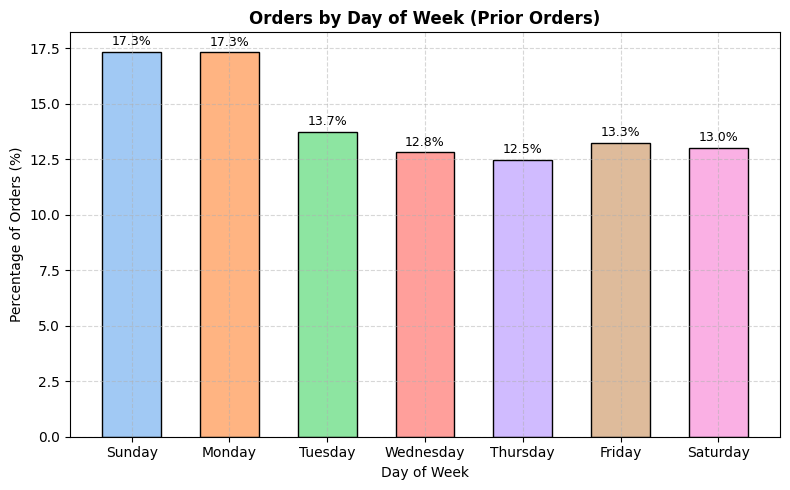

In [44]:
dow_map = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 
           4: 'Thursday', 5: 'Friday', 6: 'Saturday'}

dow_counts = (orders_prior['order_dow'].value_counts().sort_index()
              .rename_axis('order_dow').reset_index(name='orders'))

dow_counts['day'] = dow_counts['order_dow'].map(dow_map)
dow_counts['percentage'] = 100 * dow_counts['orders'] / dow_counts['orders'].sum()

# Plotting
plt.figure(figsize=(8,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
bars = plt.bar(dow_counts['day'], dow_counts['percentage'],
               color = sns.color_palette("pastel"),
               edgecolor='black',
               width = 0.6)

# Annotate bars with percentages
for bar, pct in zip(bars, dow_counts['percentage']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15, 
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.title('Orders by Day of Week (Prior Orders)', fontsize = 12, weight='bold')
plt.xlabel('Day of Week', fontsize = 10)
plt.ylabel('Percentage of Orders (%)', fontsize = 10)
plt.tight_layout()

fig_path = FIG_DIR / "EDA-01_orders_by_dow.png"
plt.savefig(fig_path, dpi=150)
plt.show()

**Interpretation.**  
Orders vary noticeably by day of week where most orders occur on Sundays and Mondays,indicating that customers tend to restock groceries at the start of the week.  
Order volume slows down from Tuesday through Saturday, suggesting less activity after initial grocery purchase.  

This pattern implies that **day-of-week** can serve as an important feature in predictive models—capturing routine behavior and planning cycles in customer purchasing habits.

#### Orders by Hour of Day

This plot displays how Instacart orders are distributed by the hour of the day (0–23).  
Understanding hourly shopping trends helps identify peak activity periods and user engagement patterns.


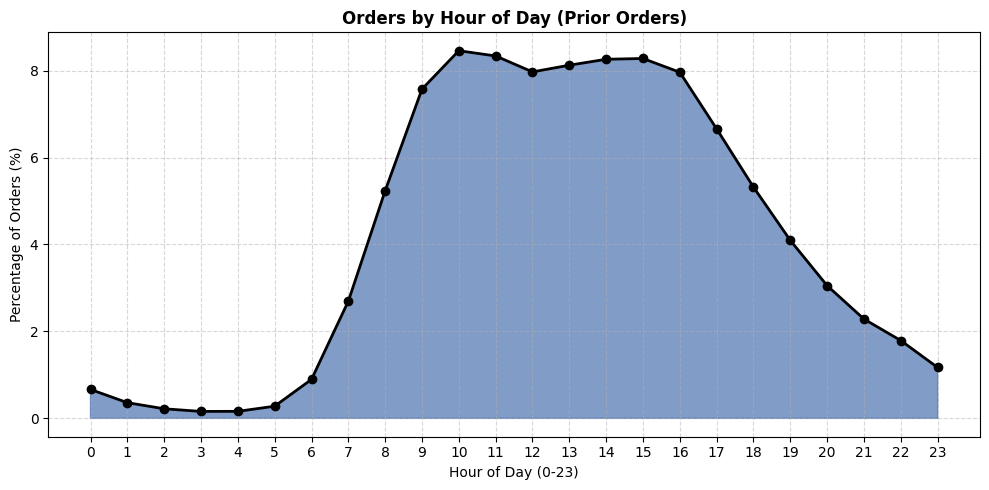

In [51]:
# Aggerate total orders by hour of day
hour_counts = (orders_prior['order_hour_of_day'].value_counts().sort_index()
               .rename_axis('order_hour_of_day').reset_index(name='orders'))

hour_counts['percentage'] = 100 * hour_counts['orders'] / hour_counts['orders'].sum()

# Plotting
plt.figure(figsize=(10,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.plot(hour_counts['order_hour_of_day'], hour_counts['percentage'],
         marker='o', color = "black", markersize=6, linewidth=2)
plt.fill_between(hour_counts['order_hour_of_day'], hour_counts['percentage'],
                 color = sns.color_palette("deep"), alpha=0.7)

plt.title('Orders by Hour of Day (Prior Orders)', fontsize = 12, weight='bold')
plt.xlabel('Hour of Day (0-23)', fontsize = 10)
plt.ylabel('Percentage of Orders (%)', fontsize = 10)
plt.xticks(range(0,24))
plt.tight_layout()

fig_path = FIG_DIR / "EDA-02_orders_by_hour.png"
plt.savefig(fig_path, dpi=150)
plt.show()




**Interpretation.**  
Order volume is lowest during late-night hours and rises sharply in the **morning**, peaking between **10 AM and 4 PM**.  After 5 PM, activity declines steadily until 6 AM next day.  

This suggests that most users place grocery orders **during midday or early afternoon**, possibly during breaks or after work.  
The clear daily rhythm supports using **hour-of-day** as a time-based feature in predictive or recommendation models.

#### Days Since Prior Order Distribution

This plot illustrates the distribution of `days_since_prior_order`, which measures the number of days between a user's current and previous orders. It helps reveal customers' ordering frequency patterns.

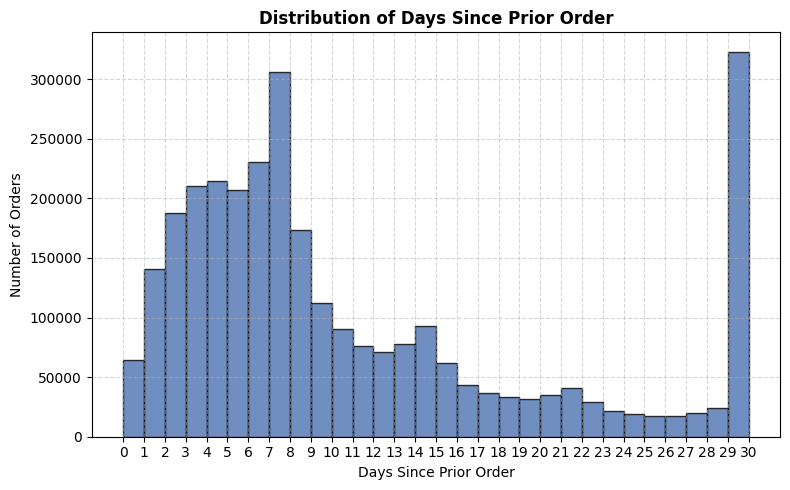

In [ ]:
# Excluding the first order (NaN days_since_prior_order)
valid_orders = orders_prior.dropna(subset=['days_since_prior_order'])

plt.figure(figsize = (8,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.hist(valid_orders['days_since_prior_order'], 
         bins = 30, color = sns.color_palette("deep")[0], 
         edgecolor='black', alpha=0.8)
plt.title('Distribution of Days Since Prior Order', fontsize = 12, weight='bold')
plt.xlabel('Days Since Prior Order', fontsize = 10)
plt.ylabel('Number of Orders', fontsize = 10)
plt.xticks(range(0,31))
plt.tight_layout()

# Save figure
fig_path = FIG_DIR / "EDA-03_days_since_prior_order.png"
plt.savefig(fig_path, dpi=150)  
plt.show()


**Interpretation.**  
The distribution shows clear peaks between **7 days - 8 days** and **29 days - 30 days**, suggesting that many customers follow **weekly** or **monthly** grocery cycles.  
A long right-tail indicates more number users reordering at those intervals.  

This recency pattern will be valuable for feature engineering `days_since_prior_order` or its transformations (e.g., recency bins) can capture user purchase cadence in later models.

#### Orders per User Distribution

This plot shows the distribution of how many orders each user has placed.  
It provides insight into customer engagement and repeat shopping behavior.


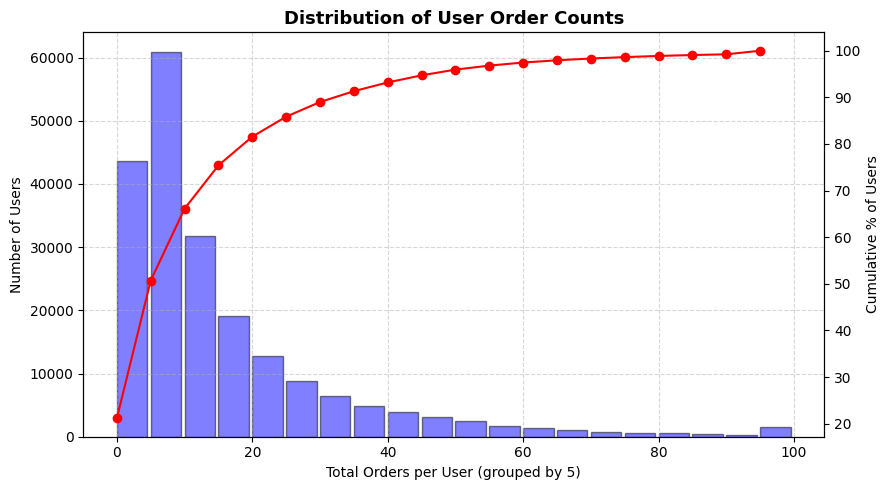

In [ ]:
# Count how many orders each user placed
user_order_counts = (orders_prior.groupby("user_id")["order_number"]
                     .max().reset_index(name = "total_orders"))

# Create bins
bins = np.arange(0, 105, 5)
hist, edges = np.histogram(user_order_counts["total_orders"], bins = bins)

# Cumulative percentage of total orders per user
cumulative = np.cumsum(hist) / user_order_counts.shape[0] * 100

fig, ax1 = plt.subplots(figsize = (9,5))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Plotting Histogram
ax1.bar(edges[:-1], hist, width = 4.5, align="edge", 
        color="blue", edgecolor="black", alpha=0.5)
ax1.set_xlabel("Total Orders per User (grouped by 5)", fontsize=10)
ax1.set_ylabel("Number of Users", color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("Distribution of User Order Counts", fontsize=13, weight="bold")

# Secondary y-axis for cumulative %
ax2 = ax1.twinx()
ax2.plot(edges[:-1], cumulative, color="red", marker="o")
ax2.set_ylabel("Cumulative % of Users", color="black")
ax2.tick_params(axis="y", labelcolor="black")

plt.tight_layout()
fig_path = FIG_DIR / "EDA-04_orders_per_user_improved.png"
plt.savefig(fig_path, dpi=150)
plt.show()


**Interpretation.**  
Most users place **fewer than 10 orders**, with over **70% of users** completing fewer than 15.The histogram’s steep left side indicates a large number of casual or first-time shoppers, while the cumulative curve shows that only a small fraction of users are highly active (30+ orders).  
This demonstrates a **long-tail user engagement pattern**; a few loyal customers account for many of the total orders. Such insights can inform retention strategies and customer segmentation.


### Product Demand